# Computer vision: LeNet-5 and Distortions
Import various modules that we need for this notebook.

In [2]:
%pylab inline

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import mnist, cifar10
from keras.models import Sequential, Graph
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

from PIL import Image

Using Theano backend.
/Users/taylor/anaconda3/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Populating the interactive namespace from numpy and matplotlib


Load the MNIST dataset, flatten the images, convert the class labels, and scale the data.

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32') / 255
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

### I. LeNet-5 for MNIST10
Here is my attempt to replicate the LeNet-5 model as closely as possibly the original paper: LeCun, Yann, Léon Bottou, Yoshua Bengio, and Patrick Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86, no. 11 (1998): 2278-2324.

As few modern neural network libraries allow for partially connected convolution layers, I've substituted this with a dropout layer. I've also replaced momentum with the Hessian approximation, and rescaled the learning rate schedule, though the proportional decay remains the same.

In [4]:
model = Sequential()

model.add(Convolution2D(6, 5, 5, border_mode='valid', input_shape = (1, 28, 28)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation("sigmoid"))

model.add(Convolution2D(16, 5, 5, border_mode='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation("sigmoid"))
model.add(Dropout(0.5))

model.add(Convolution2D(120, 1, 1, border_mode='valid'))

model.add(Flatten())
model.add(Dense(84))
model.add(Activation("sigmoid"))
model.add(Dense(10))
model.add(Activation('softmax'))

In [12]:
l_rate = 1
sgd = SGD(lr=l_rate, mu=0.8)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.fit(X_train, Y_train, batch_size=32, nb_epoch=2,
          verbose=1, show_accuracy=True, validation_data=(X_test, Y_test))

sgd = SGD(lr=0.8 * l_rate, mu=0.8)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.fit(X_train, Y_train, batch_size=32, nb_epoch=3,
          verbose=1, show_accuracy=True, validation_data=(X_test, Y_test))

sgd = SGD(lr=0.4 * l_rate, mu=0.8)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.fit(X_train, Y_train, batch_size=32, nb_epoch=3,
          verbose=1, show_accuracy=True, validation_data=(X_test, Y_test))

sgd = SGD(lr=0.2 * l_rate, mu=0.8)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.fit(X_train, Y_train, batch_size=32, nb_epoch=4,
          verbose=1, show_accuracy=True, validation_data=(X_test, Y_test))

sgd = SGD(lr=0.08 * l_rate, mu=0.8)
model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.fit(X_train, Y_train, batch_size=32, nb_epoch=8,
          verbose=1, show_accuracy=True, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 72s - loss: 0.1487 - acc: 0.9540 - val_loss: 0.0655 - val_acc: 0.9784
Epoch 2/2
60000/60000 [==============================] - 73s - loss: 0.1331 - acc: 0.9574 - val_loss: 0.0586 - val_acc: 0.9817
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 70s - loss: 0.1217 - acc: 0.9615 - val_loss: 0.0508 - val_acc: 0.9835
Epoch 2/3
60000/60000 [==============================] - 68s - loss: 0.1143 - acc: 0.9646 - val_loss: 0.0486 - val_acc: 0.9837
Epoch 3/3
60000/60000 [==============================] - 68s - loss: 0.1073 - acc: 0.9670 - val_loss: 0.0470 - val_acc: 0.9845
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 67s - loss: 0.0911 - acc: 0.9719 - val_loss: 0.0394 - val_acc: 0.9875
Epoch 2/3
60000/60000 [==============================] - 70s - loss: 0.0854 - acc: 0.973

In [13]:
print("Test classification rate %0.05f" % model.evaluate(X_test, Y_test, show_accuracy=True)[1])

10000/10000 [==============================] - 2s     
Test classification rate 0.99000


And once again, let's look at the misclassified examples.

10000/10000 [==============================] - 2s     


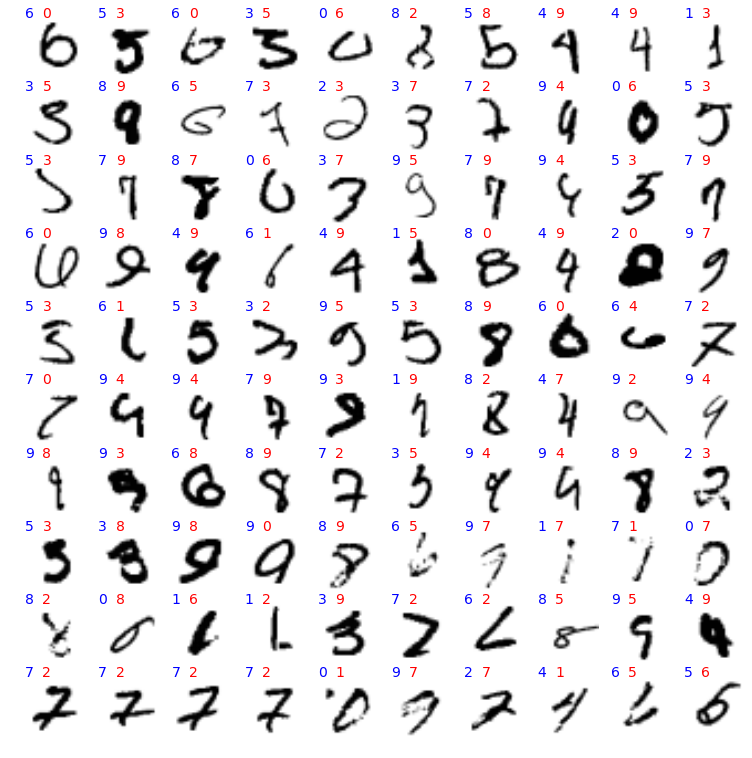

In [15]:
y_hat = model.predict_classes(X_test)
test_wrong = [im for im in zip(X_test,y_hat,y_test) if im[1] != im[2]]

plt.figure(figsize=(10, 10))
for ind, val in enumerate(test_wrong[:100]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.subplot(10, 10, ind + 1)
    im = 1 - val[0].reshape((28,28))
    plt.axis("off")
    plt.text(0, 0, val[2], fontsize=14, color='blue')
    plt.text(8, 0, val[1], fontsize=14, color='red')
    plt.imshow(im, cmap='gray')

### II. LeNet-5 with "Distortions" (i.e., Data augmentation)
The LeNet paper also introduced the idea of adding tweaks to the input data set in order to artificially increase the trainin set size. They suggested slightly distorting the image by shifting or stretching the pixels. The idea is that these distortions should not change the output image classification. Keras has a pre-built library for doing this; let us try to use it here to improve the classification rate. Note that we do not want to flip the image, as this would change the meaning of some digits (6 & 9, for example). Minor rotations are okay, however.

In [40]:
# this will do preprocessing and realtime data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

We'll use the same adaptation of LeNet-5 architecture.

In [41]:
model = Sequential()

model.add(Convolution2D(6, 5, 5, border_mode='valid', input_shape = (1, 28, 28)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation("sigmoid"))

model.add(Convolution2D(16, 5, 5, border_mode='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation("sigmoid"))
model.add(Dropout(0.5))

model.add(Convolution2D(120, 1, 1, border_mode='valid'))

model.add(Flatten())
model.add(Dense(84))
model.add(Activation("sigmoid"))
model.add(Dense(10))
model.add(Activation('softmax'))

Now we'll fit the model. Notice that the format for this is slightly different as the data is coming from `datagen.flow` rather than a single numpy array. We set the number of sample per epoch to be the same as before (60k). I am also using the non-augmented version with RMS prop for the first 2 epochs, as the details are not specified in the paper and this seems to greatly improve the convergence.

In [42]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop())
model.fit(X_train, Y_train, batch_size=32, nb_epoch=25,
          verbose=1, show_accuracy=True, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 71s - loss: 0.6566 - acc: 0.7880 - val_loss: 0.1605 - val_acc: 0.9489
Epoch 2/25
60000/60000 [==============================] - 71s - loss: 0.2248 - acc: 0.9302 - val_loss: 0.1098 - val_acc: 0.9662
Epoch 3/25
60000/60000 [==============================] - 76s - loss: 0.1778 - acc: 0.9443 - val_loss: 0.0785 - val_acc: 0.9747
Epoch 4/25
60000/60000 [==============================] - 73s - loss: 0.1497 - acc: 0.9514 - val_loss: 0.0692 - val_acc: 0.9769
Epoch 5/25
60000/60000 [==============================] - 68s - loss: 0.1387 - acc: 0.9556 - val_loss: 0.0608 - val_acc: 0.9794
Epoch 6/25
60000/60000 [==============================] - 70s - loss: 0.1265 - acc: 0.9597 - val_loss: 0.0604 - val_acc: 0.9791
Epoch 7/25
60000/60000 [==============================] - 68s - loss: 0.1219 - acc: 0.9623 - val_loss: 0.0540 - val_acc: 0.9819
Epoch 8/25
60000/60000 [==============================

How does the performance stack up? Not quite as good as the non-distorted version, though notice how the classifier does not overfit the same was as it would without the data augmentation. I have a hunch that there is something non-optimal about the RMSprop implementation when using data augmentation.

At any rate, the true advantage of data augmentation comes when we have large models (regularization) or more complex learning tasks (generalization).

In [43]:
print("Test classification rate %0.05f" % model.evaluate(X_test, Y_test, show_accuracy=True)[1])

10000/10000 [==============================] - 2s     
Test classification rate 0.98760


### III. Pure convolution
For reference, here is the architecture of a Pure Convolution network: Springenberg, J. T., Dosovitskiy, A., Brox, T., & Riedmiller, M. (2014). Striving for simplicity: The all convolutional net. arXiv preprint arXiv:1412.6806. 

In [6]:
model = Sequential()

model.add(Convolution2D(96, 5, 5, border_mode='valid', input_shape = (1, 28, 28)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
model.add(Activation("relu"))

model.add(Convolution2D(192, 5, 5, border_mode='valid'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
model.add(Activation("relu"))

model.add(Convolution2D(192, 3, 3, border_mode='valid'))
model.add(Activation("relu"))
model.add(Convolution2D(192, 1, 1, border_mode='valid'))
model.add(Activation("relu"))
model.add(Convolution2D(10, 1, 1, border_mode='valid'))
model.add(Activation("relu"))

model.add(Flatten())
model.add(Activation('softmax'))
          
rms = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=rms)